In [39]:
#0 : Promotional  5.33% 折扣、下殺 特價。。。
#1: Engagement  31.56%   按讚、打卡 分享。。。
#2: Product Awareness  28% (產品) “new product” 系列、首發、新登場、開箱、推薦 新一代 進化版
#3: Brand Awareness 8.44%（品牌）
#Corporate Social Responsibility 5.33%
#Customer Service 3.11% (粉絲) 服務 品管
#Seasonal 18.67%     開學、情人節


In [2933]:
import collections
from collections import OrderedDict

In [772]:
from pymongo import MongoClient
import json
import os.path
from numpy import array

In [35]:
client = MongoClient('mongodb://localhost:27017/')

In [36]:
db = client['fanpage_research']
coll_fanpage = db['fanpage']
coll_post = db['post']
coll_post_detail = db['post_detail']

In [500]:
import numpy as np
import pandas as pd

In [3030]:
import jieba
import jieba.analyse

In [37]:
with open('fid_list_4.json') as d:
    all_fid_list = json.load(d)

In [4235]:
jieba.set_dictionary("dict.txt.big")
stop_words_path = "data/household_stop_words.txt"
jieba.analyse.set_stop_words(stop_words_path)

In [51]:
def pp(o):
    print json.dumps(o,indent=1,ensure_ascii=False)

In [40]:
def get_combined_message_by_label(X_array, y_array, label):
    nd_X = np.array(X_array)
    nd_y = np.array(y_array)
    words = ""
    for p in nd_X[nd_y==label]:
        if p['message'] is not None:
            words = words + p['message']
    return words

In [346]:
def get_keyword(X_array, y_array, label):
    combined_message = get_combined_message_by_label(X_array, y_array, label)
    return jieba.analyse.extract_tags(combined_message, 20)

### -----------------above functions are global functions----------

In [2403]:
class industry_data:
    def __init__(self,industry_name_list,all_fid_list,file_name=None):
        self.name_list = industry_name_list
        self.name_abbr = file_name
        self.all_fid_list = all_fid_list
        self.fid_list = None
        self.posts = None
        self.train_post = None
        self.train_label = None
        self.test_post = None
        self.test_label = None
    def get_name(self):
        name = ""
        if self.name_abbr == None:
            for i in self.name_list:
                name = name + i.rsplit(' ')[0]
            self.name_abbr = name
        return self.name_abbr
    def get_fid_list(self,refresh=False):
        if self.fid_list == None or refresh == True:
            fid_list = []
            for f in self.all_fid_list:
                if f['category'] in self.name_list:
                    fid_list.append(f['fid'])
            self.fid_list = fid_list
        return self.fid_list
    def get_posts(self,refresh=False):
        fid_list = self.get_fid_list()
        if self.posts == None or refresh == True:
            posts = []
            for f in fid_list:
                posts = posts + [p for p in coll_post.find({"fid":f},{'date':False,'_id':False})]
            self.posts = posts
        return self.posts
    def get_train_post_label(self,sample_number=50,refresh=False):
        self.train_label == None
        if self.train_post == None or self.train_label == None or refresh == True:
            file_name = 'data/train_data_'+self.get_name()+'.json'
            if refresh == True or (not os.path.isfile(file_name)):
                tmp_dict = {} 
                posts = self.get_posts()
                tmp_dict['train_X'] = [p for p in np.random.choice(posts, 50, replace=False)]
                tmp_dict['train_y'] = []
                with open(file_name,'w') as outfile:
                    json.dump(tmp_dict,outfile)
            with open(file_name,'r') as infile:
                j_file = json.load(infile)
            try:
                self.train_post = j_file['train_X']
                self.train_label = j_file['train_y']
            except:
                print "error occured when accessing"+file_name+"[train_X] or [train_y]"          
        return self.train_post,self.train_label
    def get_test_post_label(self, sample_number = 50, refresh=False):
        self.test_label == None
        if self.test_post == None or self.test_label == None or refresh == True:
            file_name = 'data/test_data_'+self.get_name()+'.json'
            if refresh == True or (not os.path.isfile(file_name)):
                tmp_dict = {} 
                train_X, train_y = self.get_train_post_label()
                all_posts = self.get_posts()
                posts_without_trainX = [i for i in all_posts if i not in train_X]
                tmp_dict['test_X'] = [p for p in np.random.choice(posts_without_trainX, 50, replace=False)]
                tmp_dict['test_y'] = []
                with open(file_name,'w') as outfile:
                    json.dump(tmp_dict,outfile)
            with open(file_name,'r') as infile:
                j_file = json.load(infile)
            try:
                self.test_post = j_file['test_X']
                self.test_label = j_file['test_y']
            except:
                print "error occured when accessing"+file_name+"[test_X] or [test_y]"          
        return self.test_post,self.test_label    
    def get_keyword_category(self):
        X, y = self.get_train_post_label()
        keyword_dict = collections.OrderedDict()
        if len(X)==len(y) and len(X)!=0:
            for i in range(4):
                combined_message = get_combined_message_by_label(X, y, i)
                keyword_dict['class_'+str(i)] = jieba.analyse.extract_tags(combined_message, 10)
        return keyword_dict

In [4639]:
class Classifier:
    def __init__(self,industry):
        self.name = industry
        self.keyword_dict = None
    def get_keyword_dict(self,refresh=False):
        if self.keyword_dict == None or refresh == True:
            file_name = 'data/keyword_'+self.name+'.json'
            if os.path.isfile(file_name):
                with open(file_name,'r') as infile:
                    keyword_file = json.load(infile, object_pairs_hook=OrderedDict)
                self.keyword_dict = keyword_file
            else:
                print file_name+" doesn't exist"
                return 
        return self.keyword_dict
    def _make_ML_X(self,input_X,print_out=False):
        key_dict = self.get_keyword_dict()
        ML_X = []
        for obj in input_X:
            tmp = []
            match = []
            obj_message = obj['message']
            has_message = 0 if obj_message==None else 1
            has_vivid = 1 if obj['post_type'] in ['album','photo','cover_photo','video','video_inline',
                                                  'image_share','animated_image_share','video_direct_response'] else 0
            for k in key_dict:
                if obj_message!=None:
                    message_jieba = jieba.analyse.extract_tags(obj['message'],0)
                    match = list(set(message_jieba).intersection(key_dict[k]))
                if print_out:
                    print 'match '+k+' : ',','.join(match)
                tmp.append(len(match))
            if print_out:
                print 'has_message : ',has_message
                print 'has_vivid : ',has_vivid
            tmp.append(has_message)
            tmp.append(has_vivid)
            tmp[0] = tmp[0]*5 if tmp[0]!=0 else tmp[0]
            tmp[4] = tmp[4]*5 if tmp[4]!=0 else tmp[4]
            tmp[10] = tmp[10]/3 if tmp[4]!=0 else tmp[10]
            ML_X.append(tmp)
        return ML_X

# Machine Learning Time

In [1006]:
from sklearn import tree

In [1011]:
from sklearn.linear_model import LogisticRegression

In [4820]:
from sklearn.metrics import classification_report

In [4936]:
from sklearn import svm

In [4942]:
class ML:
    # industry_name is a list obj
    def __init__(self,industry_name_list,all_fid_list,file_name=None):
        self.industry_obj = industry_data(industry_name_list,all_fid_list,file_name)
        self.train_X, self.train_y = self.industry_obj.get_train_post_label()
        self.test_X, self.test_y = self.industry_obj.get_test_post_label()
        self.classifier = Classifier(self.industry_obj.name_abbr)
        self.ML_train_X = self.classifier._make_ML_X(self.train_X)
        self.ML_test_X = self.classifier._make_ML_X(self.test_X)
        self.model_lg = None
        self.model_tree = None
        self.model_svm = None
    def get_model_tree(self,refresh=False):
        if self.model_tree == None or refresh == True:
            clf = tree.DecisionTreeClassifier()
            clf_model = clf.fit(np.array(self.ML_train_X),np.array(self.train_y))
            self.model_tree = clf_model
        return self.model_tree
    def get_model_lg(self,refresh=False):
        if self.model_lg == None or refresh == True:
            lg = LogisticRegression()
            lg_model = lg.fit(np.array(self.ML_train_X),np.array(self.train_y))
            self.model_lg = lg_model
        return self.model_lg
    def get_model_svm(self,refresh=False):
        if self.model_svm == None or refresh == True:
            svm_t = svm.SVC()
            svm_model = svm_t.fit(np.array(self.ML_train_X),np.array(self.train_y))
            self.model_svm = svm_model
        return self.model_svm
    def _predict(self,ML_X,model='lg'):
        prediction = None
        if model == "lg":
            prediction = self.get_model_lg().predict(np.array(ML_X))
        elif model == "tree":
            prediction = self.get_model_tree().predict(np.array(ML_X))
        elif model == "svm":
            prediction = self.get_model_svm().predict(np.array(ML_X))
        return prediction
    def accuracy(self,ML_X,y,model = 'lg'):
        prediction = self._predict(ML_X,model)
        accuracy = np.mean(prediction==np.array(y))
        correct_idx = np.where(prediction==np.array(y))[0]
        incorrect_idx = np.where(prediction!=np.array(y))[0]
        print "accuracy:",accuracy
        print "correct_idx:",correct_idx
        print "incorrect_idx:",incorrect_idx 
    def checkOne(self,X,y,index,model='lg'):
        ML_X = self.classifier._make_ML_X([X[index]],print_out = True)
        print "predict class : ", self._predict(np.reshape(np.array(ML_X),(1,-1)),model)
        print "true class : ", y[index]
        print X[index]['message']
    def _classification_report(self,ML_X,y,model = 'lg'):
        prediction = self._predict(ML_X,model)
        target_names = ['class 0', 'class 1', 'class 2','class3']
        report = classification_report(y, prediction, target_names=target_names)
        return report
        

# 畫圖 method

In [4977]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4978]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [5285]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

In [5048]:
model_list = ['lg','tree','svm']

In [5049]:
# Run classifier
classifier = OneVsRestClassifier(LogisticRegression())
y_score = classifier.fit(ALL_ML.ML_train_X, ALL_ML.train_y).decision_function(ALL_ML.ML_test_X)

In [5474]:
def df_table_one(model_list):
    raw_data = OrderedDict()
    raw_data['score'] = ['Precision','Recall','F-measure','ROC']
    for i in model_list:
        raw_data[i]=[]
        raw_data[i].append(precision_score(ALL_ML.test_y, ALL_ML._predict(ALL_ML.ML_test_X,model =i), average='weighted'))
        raw_data[i].append(recall_score(ALL_ML.test_y, ALL_ML._predict(ALL_ML.ML_test_X,model =i), average='weighted'))
        raw_data[i].append(f1_score(ALL_ML.test_y, ALL_ML._predict(ALL_ML.ML_test_X,model =i), average='weighted'))
        if i == 'lg':
            classifier = OneVsRestClassifier(LogisticRegression())
        elif i == 'tree':
            classifier = OneVsRestClassifier(tree.DecisionTreeClassifier())  
        elif i == 'svm':
            classifier = OneVsRestClassifier(svm.SVC(probability=True))
        y_score = classifier.fit(ALL_ML.ML_train_X, ALL_ML.train_y).predict_proba(ALL_ML.ML_test_X)
        tmp_y_score = y_score[~np.isnan(y_score)].reshape(-1,4)
        X_ravel = np.array(zip(np.array(ALL_ML.test_y)==0,np.array(ALL_ML.test_y)==1,np.array(ALL_ML.test_y)==2,np.array(ALL_ML.test_y)==3))
        tmp_X = X_ravel[~np.isnan(y_score)].reshape(-1,4)
        raw_data[i].append(average_precision_score(tmp_X, tmp_y_score, average="weighted"))
    df = pd.DataFrame(raw_data,columns = ['score','lg','tree','svm'])
    return df

In [5275]:
def autolabel(rects,ax):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.01*height,"%.2f" % height,ha='center', va='bottom')
    return

def precision_recall_bar(model_list):
    df = df_table_one(model_list)
# Setting the positions and width for the bars
    pos = list(range(len(df['lg'])))
    width = 0.25

# Plotting the bars
    fig, ax = plt.subplots(figsize=(10,5))

    rects1 = ax.bar(pos,
        df['lg'],
        width,
        alpha=0.5,
        color='#EE3224',
        label=df['score'][0])

    rects2 = ax.bar([p + width for p in pos],
        df['tree'],
        width,
        alpha=0.5,
        color='#F78F1E',
        label=df['score'][1])

    rects3 = ax.bar([p + width*2 for p in pos],
        df['svm'],
        width,
        alpha=0.5,
        color='#FFC222',
        label=df['score'][2])

# ax.set_ylabel('Score')
# ax.set_title('Test Subject Scores')

# Set the position of the x ticks
    ax.set_xticks([p + width for p in pos])

# Set the labels for the x ticks
    ax.set_xticklabels(df['score'])

# Setting the x-axis and y-axis limits
    plt.xlim(min(pos)-width*2, max(pos)+width*3)
    plt.ylim([0, 1] )


    autolabel(rects1,ax)
    autolabel(rects2,ax)        
    autolabel(rects3,ax)        

# Adding the legend and showing the plot
    plt.legend(['LogisticRegression', 'DecisionTree', 'SVM'], loc='lower left')
    plt.grid()
    plt.show()

In [5476]:
def _precision_recall_curve(model_list):
    average_curve_data = OrderedDict()
    colors = cycle(['navy', 'turquoise', 'darkorange'])
    lw = 2
    y = ALL_ML.train_y+ALL_ML.test_y
    # Binarize the output
    y = label_binarize(y, classes=[0, 1, 2, 3])
    n_classes = y.shape[1]
    plt.clf()
    for i,color in zip(model_list,colors):
        if i == 'lg':
            classifier = OneVsRestClassifier(LogisticRegression())
        elif i == 'tree':
            classifier = OneVsRestClassifier(tree.DecisionTreeClassifier())  
        elif i == 'svm':
            classifier = OneVsRestClassifier(svm.SVC(probability=True))
        y_score = classifier.fit(ALL_ML.ML_train_X, ALL_ML.train_y).predict_proba(ALL_ML.ML_test_X)
        # rule out NaN
        tmp_y_score = y_score[~np.isnan(y_score)].reshape(-1,4)
        X_ravel = np.array(zip(np.array(ALL_ML.test_y)==0,np.array(ALL_ML.test_y)==1,np.array(ALL_ML.test_y)==2,np.array(ALL_ML.test_y)==3))
        tmp_X = X_ravel[~np.isnan(y_score)].reshape(-1,4)

    # Compute micro-average ROC curve, ROC area and breakeven point
        precision["micro"], recall["micro"], _ = precision_recall_curve(tmp_X.ravel(),tmp_y_score.ravel())
        average_precision["micro"] = average_precision_score(tmp_X, tmp_y_score,average="weighted")
    # Draw intersection line          
        x = recall["micro"]
        y = recall["micro"]
        plt.plot(x,y,  '-')
        breakeven_idx = np.argwhere(np.diff(np.sign(precision["micro"] - y)) != 0).reshape(-1) + 0
    # Plot Precision-Recall curve for each class
        plt.plot(recall["micro"], precision["micro"], color=color, lw=lw,
                label= i +' (breakeven point = {0:0.2f})'
               .format(precision["micro"][breakeven_idx][0]))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower right")
    plt.show()

# All dataset

In [4944]:
ALL_ML = ML(["all"],all_fid_list,file_name = "all")

In [5478]:
print ALL_ML.accuracy(ALL_ML.ML_test_X, ALL_ML.test_y,"lg")
print ALL_ML.accuracy(ALL_ML.ML_test_X, ALL_ML.test_y,"tree")
print ALL_ML.accuracy(ALL_ML.ML_test_X, ALL_ML.test_y,"svm")

accuracy: 0.9
correct_idx: [  0   1   2   3   4   6   8   9  10  11  12  13  14  15  16  17  18  20
  21  23  24  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58
  59  61  62  63  64  66  67  68  69  70  72  73  74  77  78  79  80  81
  82  83  84  85  86  87  88  90  91  92  93  94  95  96  97  98  99 100
 101 103 104 105 106 107 108 109 110 111 112 113 114 115 116 119 120 122
 123 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 145 146 147 148 149 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199]
incorrect_idx: [  5   7  19  22  25  60  65  71  75  76  89 102 117 118 121 124 144 150
 151 170]
None
accuracy: 0.845
correct_idx: [  1   2   3   4   8   9  10  11  12  13  14  16  17  18  20  21  23  24
  25  26  27  28  29  30  32  33  35 

In [5468]:
print ALL_ML._classification_report(ALL_ML.ML_test_X, ALL_ML.test_y,"lg")
print ALL_ML._classification_report(ALL_ML.ML_test_X, ALL_ML.test_y,"tree")
print ALL_ML._classification_report(ALL_ML.ML_test_X, ALL_ML.test_y,"svm")

             precision    recall  f1-score   support

    class 0       0.90      0.93      0.91        40
    class 1       0.96      0.86      0.90        76
    class 2       0.85      0.95      0.90        41
     class3       0.87      0.91      0.89        43

avg / total       0.90      0.90      0.90       200

             precision    recall  f1-score   support

    class 0       0.75      0.82      0.79        40
    class 1       0.95      0.76      0.85        76
    class 2       0.90      0.90      0.90        41
     class3       0.76      0.95      0.85        43

avg / total       0.86      0.84      0.85       200

             precision    recall  f1-score   support

    class 0       0.80      0.88      0.83        40
    class 1       0.92      0.71      0.80        76
    class 2       0.88      0.90      0.89        41
     class3       0.75      0.95      0.84        43

avg / total       0.85      0.83      0.83       200



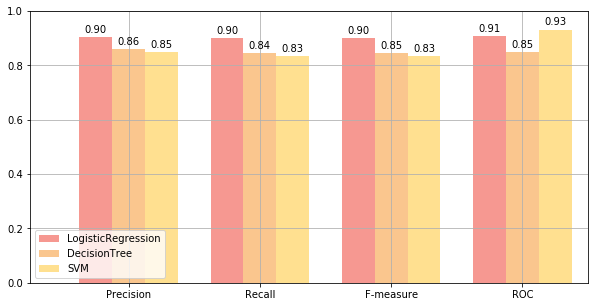

In [5475]:
precision_recall_bar(model_list)

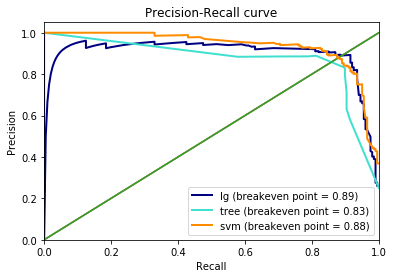

In [5477]:
_precision_recall_curve(model_list)

In [5257]:
#ALL_ML.checkOne(ALL_ML.test_X,ALL_ML.test_y,10,"lg")

# update class function

In [4692]:
update_class(f_file,"data/train_data_all.json",151,1)

In [4683]:
with open("data/train_data_all.json") as ff:
    f_file = json.load(ff)

In [4684]:
def update_class(loaded_file, file_name, index,new_class):
    loaded_file['train_y'][index] = new_class
    with open(file_name,'w') as o_ff:
        json.dump(loaded_file,o_ff)

In [4800]:
print ','.join(jieba.analyse.extract_tags(ALL_ML.test_X[0]['message'], 20))

兒童,免費,FRIDAYS,兒童節,優惠,消費,活動,TGI,餐廳,餐點,招待,餐券,古亭,服務費,tgifridays,歡慶,頁面,辦法,時代,請見


In [4801]:
print ALL_ML.test_X[0]['message']

把拔馬麻們注意囉📢📢📢 
🎉 歡慶兒童節🎉 
TGI FRIDAYS Taiwan要請小朋友們吃免費兒童餐喔！ 

4/4兒童節當天用餐並出示此活動頁面👆， 
於指定餐廳 (美麗華、西門、古亭、林森、桃園、 
台中市政、台中英才、台南新天地、高雄夢時代) 
☝消費滿1000元，免費招待1份兒童餐點！ 
✌消費滿2000元，免費招待2份兒童餐點！ (以此類推) 

爸爸媽媽們快點帶家裡的寶貝們到FRIDAYS慶祝兒童節喔！🎉🎈 
各餐廳訂位電話與營業時間請見：http://www.tgifridays.com.tw/store.php

※兒童餐優惠僅提供12歲以下兒童享用。 
※贈送品項需加收原價之10%服務費。 
※不得與EZ Table餐券、網路會員優惠或其它優惠活動同時使用。 
※不得折現或外帶，TGI FRIDAYS保有修改活動辦法之權利
